If I don't prevent OpenMP threading, I end up with a *ton* of system time from multithreaded BLAS that actually lowers performance:

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import arviz as az
from emcee import EnsembleSampler
import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np
import pymc3 as pm
import pymc3_ext as pmx
import scipy.linalg as sl
import scipy.stats as ss
import starry
from starry import Map, System, Primary, Secondary
import starry_process
from starry_process import StarryProcess
import theano
theano.config.gcc__cxxflags += " -fexceptions"
theano.config.on_opt_error = "raise"
theano.tensor.opt.constant_folding
theano.graph.opt.EquilibriumOptimizer
import theano.tensor as tt
from theano.tensor.random.utils import RandomStream
from tqdm.notebook import tqdm
from corner import corner

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Formulas:
$$
N\left( f \mid M y, C \right) N\left( y \mid \mu, \Lambda \right) = N\left( y \mid a, A \right) N\left( f \mid b, B \right)
$$
where
$$
A^{-1} = \Lambda^{-1} + M^T C^{-1} M
$$
$$
a = A \left( \Lambda^{-1} \mu + M^T C^{-1} M f \right)
$$
$$
b = M \mu
$$
$$
B = C + M \Lambda M^T
$$

Useful re-writing:
$$
A = \left( I + \Lambda M^T C^{-1} M \right)^{-1} \Lambda
$$

$$
B^{-1} = C^{-1} - C^{-1} M \left( I + \Lambda M^T C^{-1} M \right)^{-1} \Lambda M^T C^{-1}
$$

In [4]:
def _cho_solve(L, b):
    return tt.slinalg.solve_upper_triangular(L.T, tt.slinalg.solve_lower_triangular(L, b))

class StarryStarryProcess(object):
    def __init__(self, sys, sp, nt, nlm):
        self._sys = sys
        self._sp = sp
        self._nt = nt
        self._nlm = nlm

        self._mu = sp.mean_ylm
        self._Lambda = sp.cov_ylm

    @property
    def nt(self):
        return self._nt
    @property
    def nlm(self):
        return self._nlm

    @property
    def sys(self):
        return self._sys
    @property
    def sp(self):
        return self._sp
    
    @property
    def mu(self):
        return self._mu
    @property
    def Lambda(self):
        return self._Lambda
    
    @property
    def primary(self):
        return self.sys.primary
    @property
    def secondary(self):
        return self.sys.secondaries[0]
    
    @property
    def design_matrix(self):
        return self._M

    @property
    def logl_marginal(self):
        return self._logl_marginal
    @property
    def a(self):
        return self._a
    @property
    def AInv_chol(self):
        return self._AInv_chol

    def _compute(self, t, flux, sigma_flux):
        M = self.sys.design_matrix(t)[:,:-1] # We don't use any flux from the secondary, so [:, :-1]
        self._M = M

        nlm = self.nlm
        nt = self.nt

        mu = self.mu
        Lambda = self.Lambda

        # We want to enforce that the prior on the constant term in the map is
        # completely flat, so we set the first row and column of the precision
        # matrix to zero we do this manually here.  First we Cholesky decompose:
        #
        # Lambda[1:,1:] = L L^T
        #
        # Then, because of a quirk of theano (no gradients for `cho_solve!`,
        # WTF), we can compute Lambda[1:,1:]^{-1} via
        #
        # Lambda[1:,1:]^{-1} = tt.slinalg.solve_triangular(L.T, tt.slinalg.solve_triangular(L, tt.eye(nlm-1), lower=True), lower=False)
        #
        # encapsulated in our _cho_solve(...) function above
        L = tt.slinalg.cholesky(Lambda[1:,1:])
        Lambda_inv = _cho_solve(L, tt.eye(nlm-1))
        Lambda_inv = tt.set_subtensor(tt.zeros((nlm, nlm))[1:,1:], Lambda_inv)

        sigma_flux2 = tt.square(sigma_flux)
        MTCinv = M.T / sigma_flux2[None, :]
        MTCinvM = tt.dot(MTCinv, M)

        AInv = Lambda_inv + MTCinvM
        AInv_chol = tt.slinalg.cholesky(AInv)
        a = _cho_solve(AInv_chol, tt.dot(Lambda_inv, mu) + tt.dot(MTCinv, flux))

        self._a = a
        self._AInv_chol = AInv_chol

        b = tt.dot(M, mu)
        r = flux - b

        Cinvr = r / sigma_flux2

        rtilde = Cinvr - tt.dot(MTCinv.T, tt.slinalg.solve(AInv, tt.dot(MTCinv, r)))

        # Identity:
        # |B| = |I + M^T C^-1 M L| |C| = |L^-1 + M^T C^-1 M| |L| |C|
        # But we want to cancel the infinite constant in L[0,0], so we ignore the first row and column of L:
        # |B| = | A^-1 | |L[1:,1:]| |C|

        logdetB = tt.sum(tt.log(sigma_flux2)) + 2*tt.sum(tt.log(tt.diag(AInv_chol))) + 2*tt.sum(tt.log(tt.diag(L)))

        # (nt-1) because we have cancelled one dimension due to the flat prior on the [0,0] constant term.
        logl = -0.5*tt.dot(r, rtilde) - 0.5*logdetB - 0.5*(nt-1)*tt.log(2*np.pi)
        self._logl_marginal = logl

    def marginal_likelihood(self, t, flux, sigma_flux):
        self._compute(t, flux, sigma_flux)
        return self.logl_marginal
    
    def sample_ylm_conditional(self, t, flux, sigma_flux, size=1, rng=None):
        if rng is None:
            rng = RandomStream(seed=np.random.randint(1<<32))

        nylm = self.nlm

        self._compute(t, flux, sigma_flux)
        return self.a[None,:] + tt.slinalg.solve_upper_triangular(self.AInv_chol.T, rng.normal(size=(nylm, size))).T

In [5]:
starry.config.lazy = True

ydeg = 15
udeg = 2

u1 = 0.4
u2 = 0.26

r = 20.0
dr = 5.0
n = 1
c = 0.5
mu = 30.0
sigma = 5.0

prot = 30.0
porb = 4.887802443

stellar_inc = 90.0
stellar_obl = -30.0

rng = np.random.default_rng(302592346730275158208684369480422136411)

pri = Primary(starry.Map(ydeg, udeg=udeg, inc=stellar_inc, obl=stellar_obl),
              r=0.683, m=0.81, prot=prot, t0=0.0)
sec = Secondary(starry.Map(0, 0), 
                t0=0, r=0.04*pri.r.eval(), m=1e-3*pri.m.eval(), prot=1.0,
                porb=porb, ecc=0.0, Omega=100, inc=90)
pri.map[1] = u1
pri.map[2] = u2

sys = System(pri, sec)

Ttr_half = 0.1
dt_in_transit = Ttr_half / 20.0
dt_out_transit = prot / 20.0

sp = StarryProcess(n=n, mu=mu, sigma=sigma, r=r, dr=dr, ydeg=ydeg, udeg=udeg, marginalize_over_inclination=False, seed=rng.integers(0, 1<<32))

y_true = sp.sample_ylm().eval()[0,:]
y_true[0] = 1.0

T = 3*prot
t_in = np.arange(-T, T, dt_in_transit)
t_out = np.arange(-T, T, dt_out_transit)

t_in_transit = (t_in % sec.porb.eval() < Ttr_half) | (t_in % sec.porb.eval() > sec.porb.eval()-Ttr_half)
t_out_transit = (t_out % sec.porb.eval() < Ttr_half) | (t_out % sec.porb.eval() > sec.porb.eval()-Ttr_half)

t = np.sort(np.concatenate((
    t_in[t_in_transit],
    t_out[~t_out_transit],
)))
nt = len(t)

flux_true = sys.design_matrix(t).eval()[:, :-1] @ y_true

sigma_flux = 1e-4*np.ones_like(flux_true)

flux_obs = flux_true + sigma_flux*rng.normal(size=nt)

ssp = StarryStarryProcess(sys, sp, nt, len(pri.map.y.eval()))

Pre-computing some matrices... Done.
Pre-computing some matrices... Done.


In [6]:
len(t)

1597

/Users/sabina/Desktop/GitHub/starry_process/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


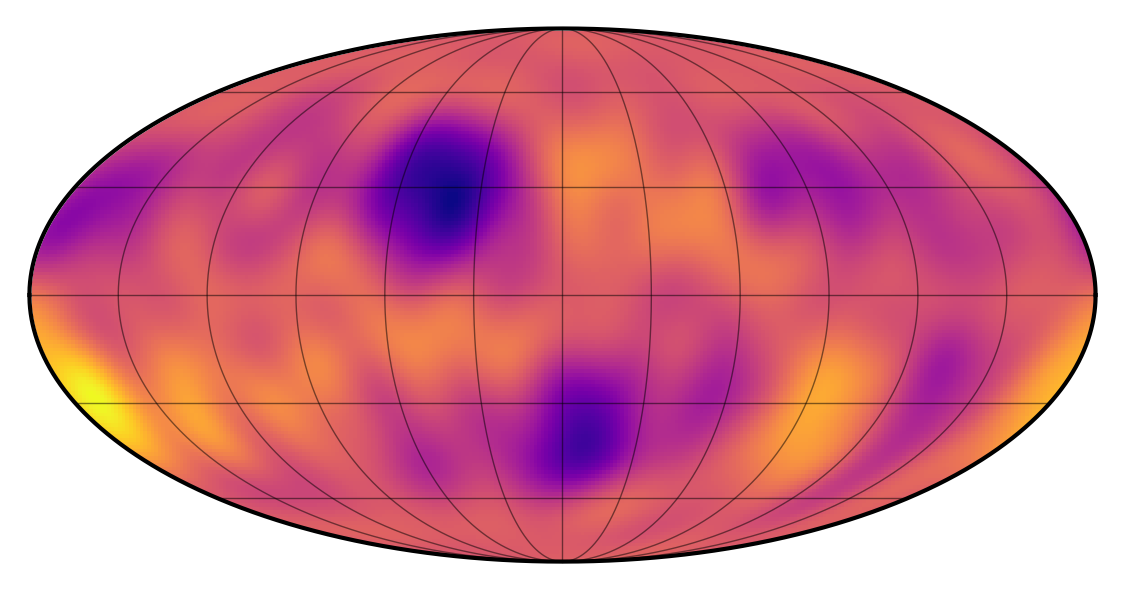

In [7]:
sp.visualize(y_true)

<ErrorbarContainer object of 3 artists>

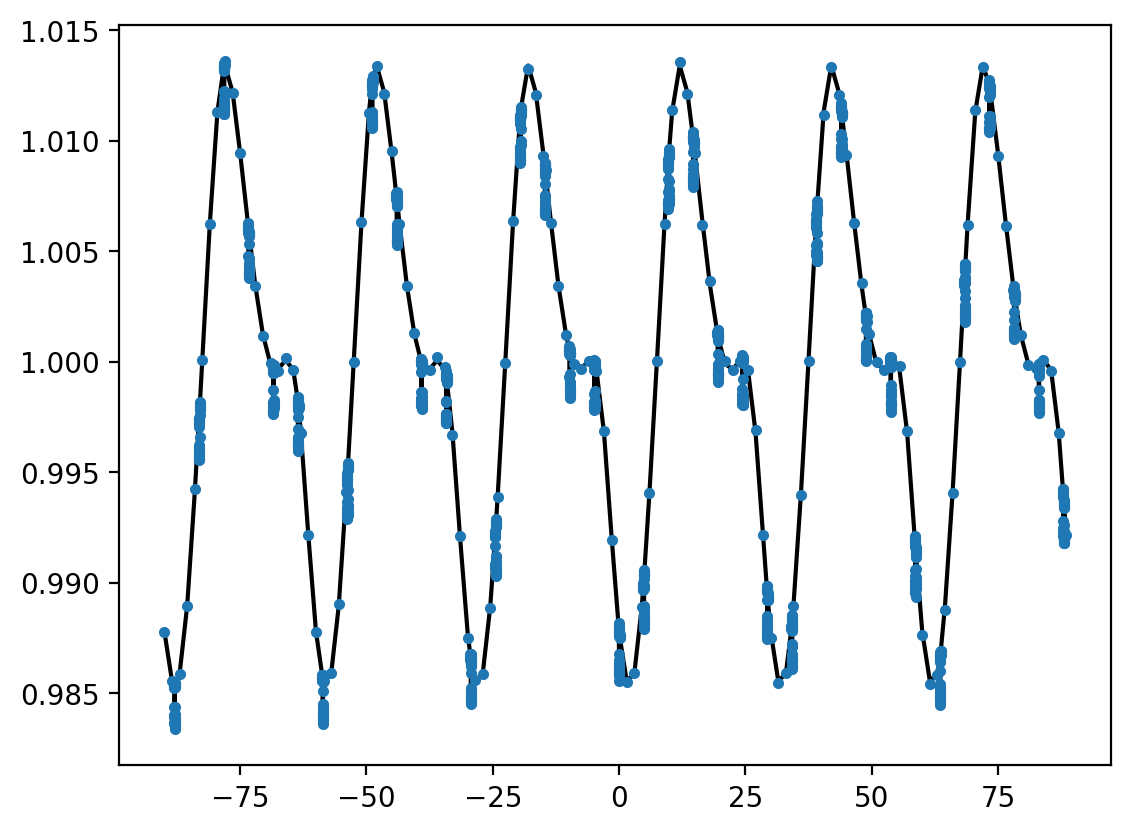

In [8]:
plt.plot(t, flux_true, color='k')
plt.errorbar(t, flux_obs, yerr=sigma_flux, fmt='.')

In [9]:
sys.show(t=t[::2], window_pad=4, figsize=(8, 8))

Compiling `compute_rect_grid`... Done.
Compiling `compute_moll_grid`... Done.
Compiling `compute_ortho_grid`... Done.
Compiling `compute_rect_grid`... Done.
Compiling `compute_moll_grid`... Done.
Compiling `compute_ortho_grid`... Done.


Pre-computing some matrices... Done.
Compiling `render`... Done.


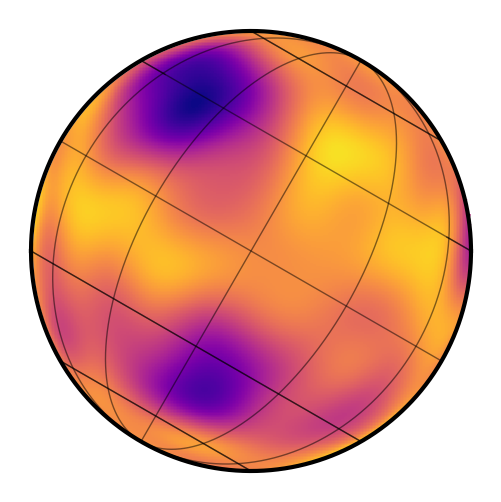

In [10]:
map = starry.Map(ydeg, udeg=udeg, inc=stellar_inc, obl=stellar_obl)
map[:,:] = y_true
map.show()

In [11]:
xo, yo, zo = sys.position(t)
xo = xo[1].eval()
yo = yo[1].eval()
zo = zo[1].eval()

In [12]:
theta = (360 * t / 10.0) % 360

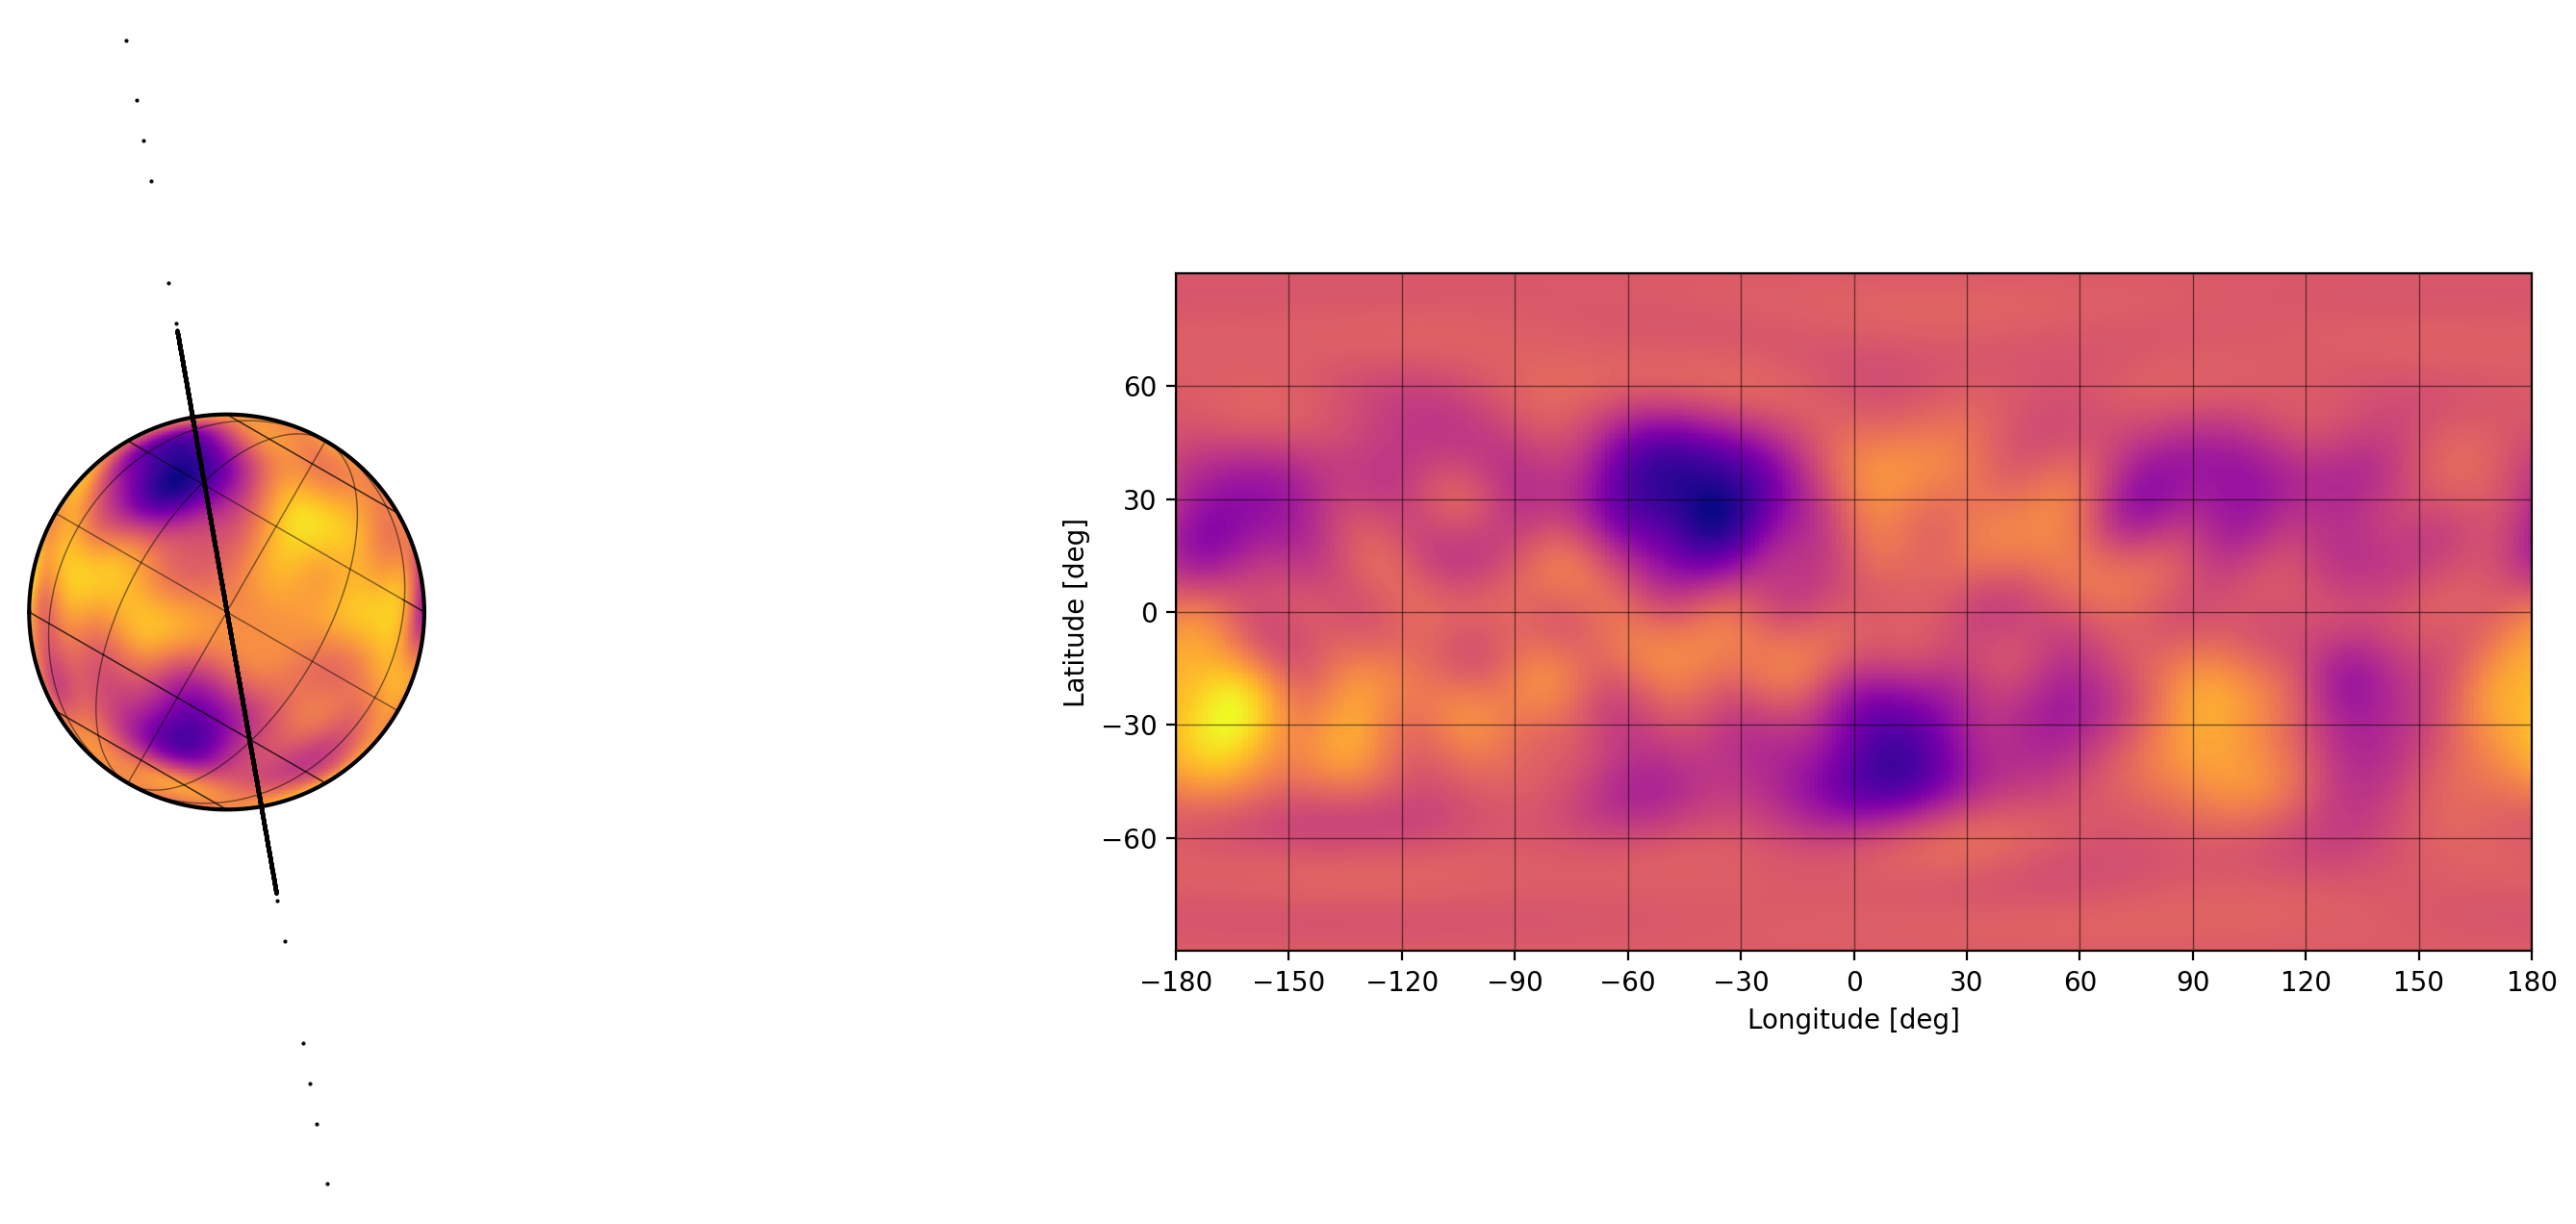

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
idx = (zo > 0) | (xo ** 2 + yo ** 2 > 1)
ax[0].plot(xo[idx], yo[idx], "k.", ms=1);
ax[0].set_aspect(1)
ax[0].axis("off")
# map[:, :] = y
map.show(ax=ax[0])
ax[0].set_ylim(-3, 3)
idx = (zo > 0) & (xo ** 2 + yo ** 2 < 1)
lat = 180 / np.pi * np.arcsin(yo[idx])
lon = 180 / np.pi * np.arcsin(xo[idx] / np.sqrt(1 - yo[idx] ** 2)) - theta[idx]
lon = (lon + 180) % 360 - 180
mask = np.append(np.array(lon[1:] > lon[:-1], dtype=float), 0)
mask[mask == 1] = np.nan
map.show(ax=ax[1], projection="rect")
# ax[1].plot(lon, lat, "k.");

<ErrorbarContainer object of 3 artists>

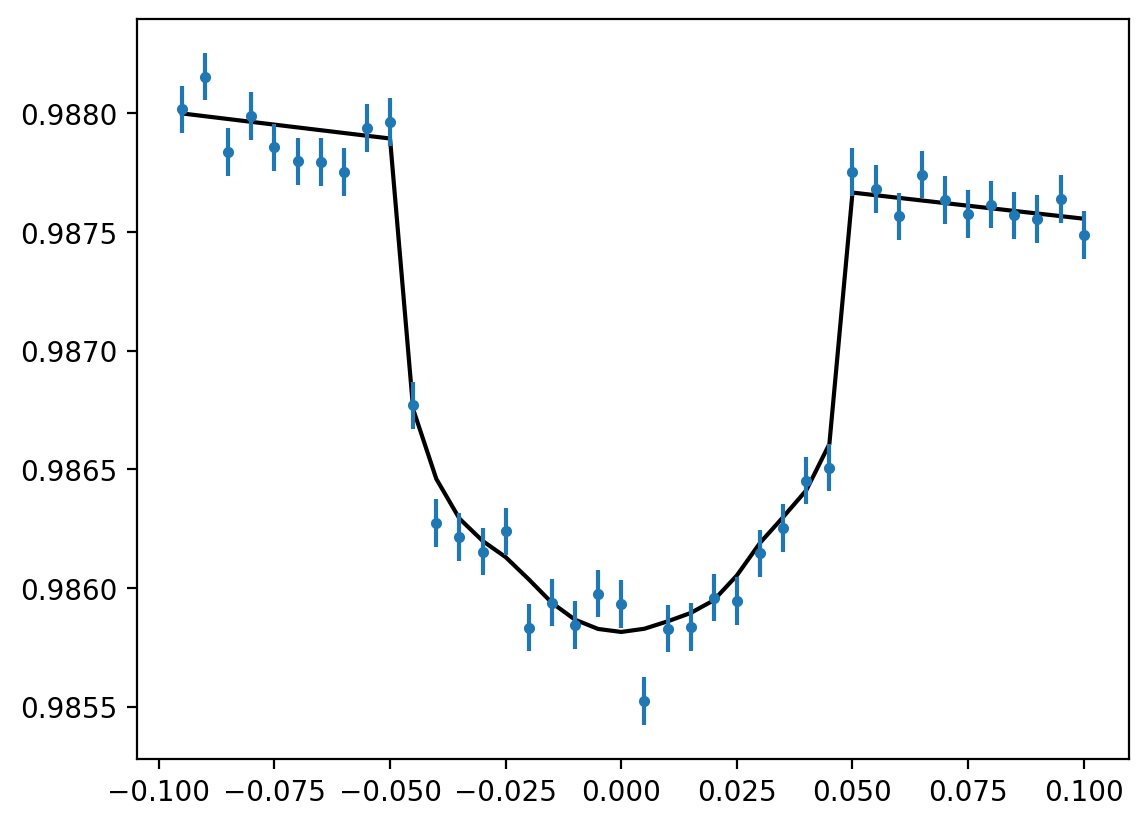

In [14]:
sel = np.abs(t) < sec.porb.eval()/10
plt.plot(t[sel], flux_true[sel], color='k')
plt.errorbar(t[sel], flux_obs[sel], yerr=sigma_flux[sel], fmt='.')

In [15]:
ylm_draw = ssp.sample_ylm_conditional(t, flux_obs, sigma_flux).eval()[0,:]

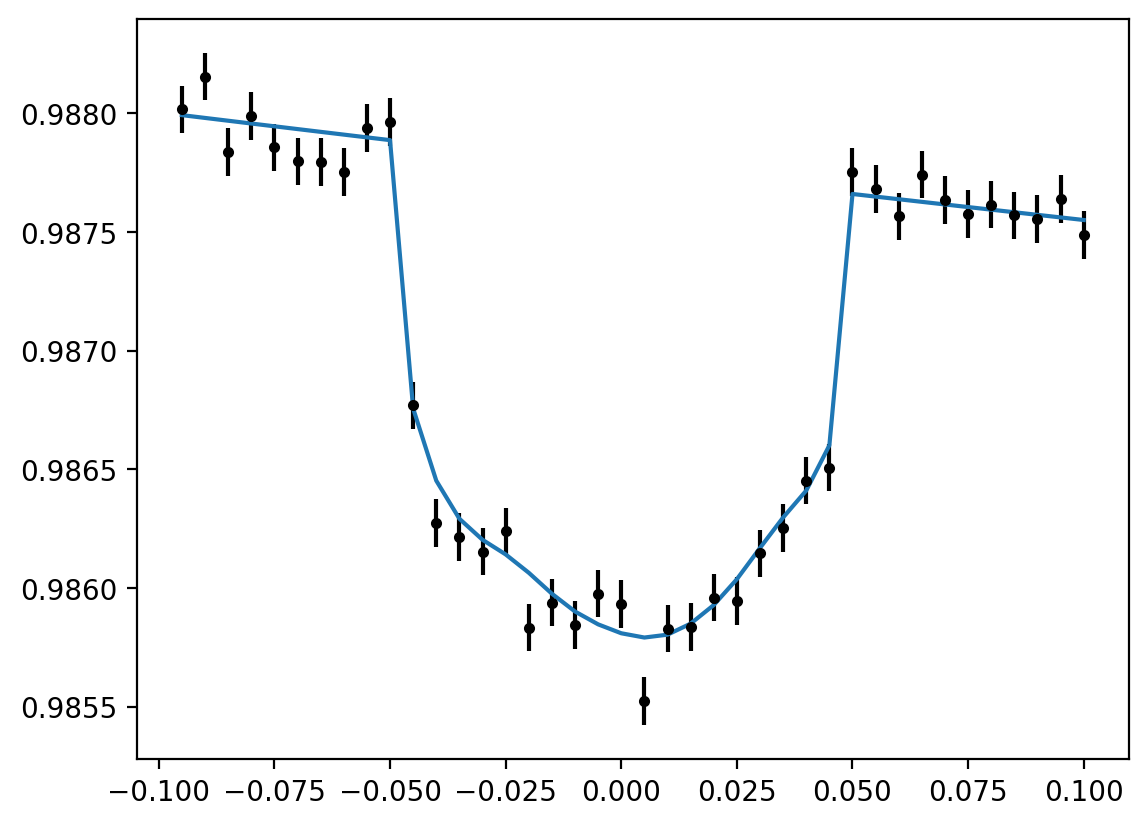

In [16]:
plt.errorbar(t[sel], flux_obs[sel], yerr=sigma_flux[sel], fmt='.', color='k')
plt.plot(t[sel], (ssp.design_matrix.eval() @ ssp.a.eval())[sel])

/Users/sabina/Desktop/GitHub/starry_process/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


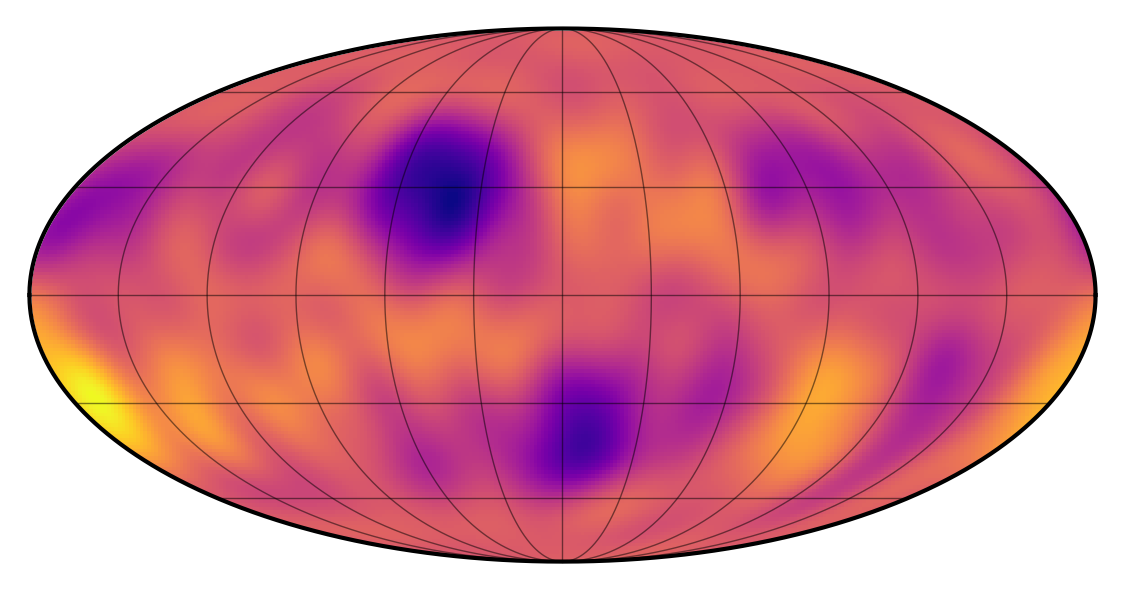

In [17]:
sp.visualize(y_true)

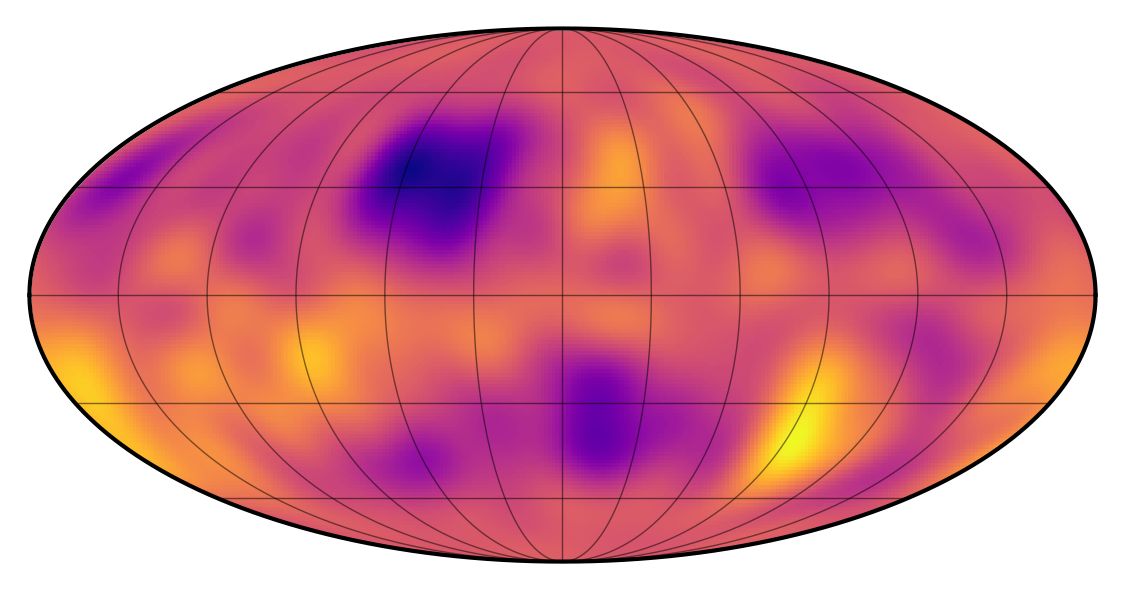

In [18]:
sp.visualize(ylm_draw)

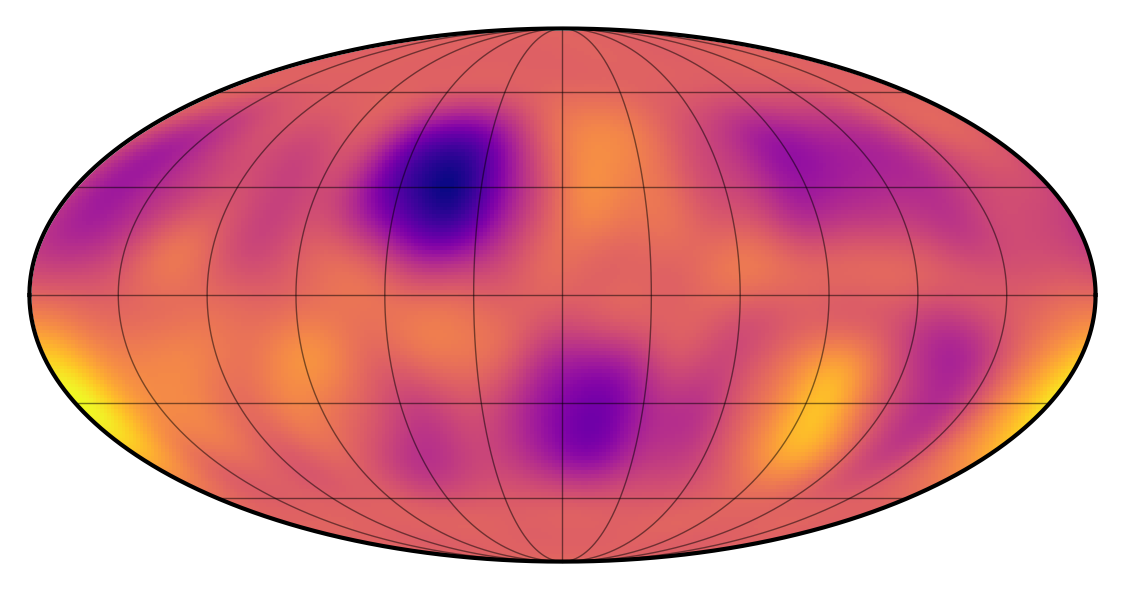

In [19]:
sp.visualize(ssp.a.eval())

Let's double-check the Gaussian factorization; the next two cells should give identical log-likelihoods:

In [20]:
resid = flux_obs - ssp.design_matrix.eval() @ ylm_draw
np.sum(ss.norm(loc=0, scale=sigma_flux).logpdf(resid)) - 0.5*np.dot(ylm_draw[1:] - sp.mean_ylm.eval()[1:], np.linalg.solve(sp.cov_ylm.eval()[1:,1:], ylm_draw[1:] - sp.mean_ylm.eval()[1:])) - 0.5*np.linalg.slogdet(sp.cov_ylm.eval()[1:,1:])[1] - 0.5*(len(ylm_draw)-1)*np.log(2*np.pi)

13978.822478030152

In [21]:
whitened_ylm_resid = np.dot(ssp.AInv_chol.T.eval(), ylm_draw - ssp.a.eval())
ssp.marginal_likelihood(t, flux_obs, sigma_flux).eval() - 0.5*np.dot(whitened_ylm_resid, whitened_ylm_resid) + np.sum(np.log(np.diag(ssp.AInv_chol.eval()))) - 0.5*len(ylm_draw)*np.log(2*np.pi)

13978.82245950691

The marginal likelihood is:

In [22]:
ssp.marginal_likelihood(t, flux_obs, sigma_flux).eval()

array(12374.84133954)

In [23]:
pri.map[:,:] = ylm_draw
sys.show(t[::2]) # , file='/Users/wfarr/Downloads/Hat-P-11b-analog.mp4')

Let's try some fitting

Note: the below will error-out due to a singularity in the `_x`, `_y`, `_z` variables at the origin.  The reason is: the MAP values of those are all zero, approaching the origin with an angle that is the MAP value of `obl` and `inc`.  But this generates a `0/0` loss of precision.  This isn't a problem for *sampling* because the origin occupies a set of zero volume---so ("almost surely all of") the samples live far from the origin clustered around the correct angle.

## fitting

In [24]:
Ttotal = t[-1] - t[0]
prot_frac_bounds = min(prot/Ttotal/2, 0.25)
porb_frac_bounds = min(porb/Ttotal/2, 0.25)

t0_bounds = 0.2 # Hard coded!

a = (pri.m.eval()*np.square(sec.porb.eval()/365.25))**(1/3) * 215.03 # Solar radii
bmax = pri.r.eval() / a

with pm.Model() as model:
    log_prot = pm.Uniform('log_prot', np.log(prot) + np.log1p(-prot_frac_bounds), np.log(prot) + np.log1p(prot_frac_bounds))
    prot = pm.Deterministic('prot', tt.exp(log_prot))

    log_porb = pm.Uniform('log_porb', np.log(porb) + np.log1p(-porb_frac_bounds), np.log(porb) + np.log1p(porb_frac_bounds))
    porb = pm.Deterministic('porb', tt.exp(log_porb))

    t0 = pm.Uniform('t0', -t0_bounds, t0_bounds)

    log_rp = pm.Uniform('log_rp', np.log(sec.r.eval()/2), np.log(2*sec.r.eval()))
    rp = pm.Deterministic('rp', tt.exp(log_rp))

    # For some reason, the model errors out if I try to use Omega as a variable
    # on the planetary transit, but it's happy to have a stellar obliquity.
    # Since only the *relative* angle between transit and star is observable
    # anyway, this is the only relevant degree of freedom.  (Visualize: rotate
    # the star-planet system in the sky until the planet's orbit is "horizontal"
    # (zero obliquity).  The lightcurve is still the same.)  So the preferred
    # value of the stellar obliquity will be -Omega from above, and we pass
    # Omega = 0 to the planet below.
    stellar_ori_x = pm.Normal('stellar_ori_x', mu=0, sigma=1, testval=1)
    stellar_ori_y = pm.Normal('stellar_ori_y', mu=0, sigma=1, testval=1)
    stellar_ori_z = pm.Normal('stellar_ori_z', mu=0, sigma=1, testval=1)
    stellar_obl = pm.Deterministic('stellar_obl', 180.0/np.pi*tt.arctan2(stellar_ori_y, stellar_ori_x))
    stellar_inc = pm.Deterministic('stellar_inc', 180.0/np.pi*tt.arccos(stellar_ori_z / tt.sqrt(tt.square(stellar_ori_x) + tt.square(stellar_ori_y) + tt.square(stellar_ori_z))))

    # Impact parameter
    b = pm.Uniform('b', -bmax, bmax)
    planet_inc = pm.Deterministic('planet_inc', 180.0/np.pi*np.arccos(b))


    pri_model = Primary(starry.Map(ydeg=ydeg, udeg=udeg, inc=stellar_inc, obl=stellar_obl), r=float(pri.r.eval()), m=float(pri.m.eval()), prot=prot, t0=0.0)
    pri_model.map[1] = u1
    pri_model.map[2] = u2

    #spin-orbit misalignment angle
    # Omega = pm.Deterministic('Omega', tt.arccos(b * tt.cos(stellar_obl) / (rp / float(pri.r.eval())) - tt.cos(stellar_inc)))
    # Omega = pm.Deterministic('Omega', stellar_obl + stellar_inc)
    Omega = pm.Uniform('Omega', 0, 180)

    sec_model = Secondary(starry.Map(0,0), 
                          t0=t0, r=rp, m=float(sec.m.eval()), prot=float(sec.prot.eval()),
                          porb=porb, ecc=float(sec.ecc), Omega=Omega, inc=planet_inc)
    
    sys_model = System(pri_model, sec_model)

    mu = pm.Uniform('mu', 0, 80)
    sigma = pm.Uniform('sigma', 1., 10.)
    r = pm.Uniform('r', 5., 25.)
    c = pm.Uniform('c', 0.1, 1.)

    sp_model = StarryProcess(n=n, 
                             mu=mu,
                             sigma=sigma,
                             r=r,
                             dr=tt.as_tensor_variable(dr, 'dr'),
                             c=c,
                             ydeg=ydeg, udeg=udeg, 
                             marginalize_over_inclination=False,)

    # Normally we would make another StarryProcess here, but because none of its parameters are being set in the model for now, we can just reuse `sp`
    ssp_model = StarryStarryProcess(sys_model, sp_model, nt, len(pri.map.y.eval()))

    pm.Potential('marginal_likelihood', ssp_model.marginal_likelihood(t, flux_obs, sigma_flux))

Pre-computing some matrices... Done.
Pre-computing some matrices... Done.


In [25]:
with model:
    map_soln = pmx.optimize(maxeval=500)

optimizing logp for variables: [c, r, sigma, mu, Omega, b, stellar_ori_z, stellar_ori_y, stellar_ori_x, log_rp, t0, log_porb, log_prot]


message: Desired error not necessarily achieved due to precision loss.
logp: 5835.039267793123 -> 12269.641938453064


In [26]:
map_soln

{'log_prot_interval__': array(0.08458984),
 'log_porb_interval__': array(0.0136942),
 't0_interval__': array(-0.00103769),
 'log_rp_interval__': array(-0.00474793),
 'stellar_ori_x': array(0.05609211),
 'stellar_ori_y': array(0.06485417),
 'stellar_ori_z': array(0.08190973),
 'b_interval__': array(-0.11342775),
 'Omega_interval__': array(-0.25314304),
 'mu_interval__': array(-0.71328049),
 'sigma_interval__': array(-0.96422313),
 'r_interval__': array(-0.47068026),
 'c_interval__': array(-1.46624236),
 'log_prot': array(3.40121451),
 'prot': array(30.00051372),
 'log_porb': array(1.58674282),
 'porb': array(4.88780252),
 't0': array(-0.00010377),
 'log_rp': array(-3.60178175),
 'rp': array(0.02727508),
 'stellar_obl': array(49.14360453),
 'stellar_inc': array(46.31082505),
 'b': array(-0.0034248),
 'planet_inc': array(90.1962269),
 'Omega': array(78.66900747),
 'mu': array(26.30995014),
 'sigma': array(3.48430106),
 'r': array(12.68910498),
 'c': array(0.26876299)}

In [27]:
start = dict(t0=0.0, stellar_ori_x=np.cos(-30*np.pi/180), stellar_ori_y=np.sin(-30*np.pi/180), stellar_ori_z=0.0, b=0.0, log_prot=np.log(30.0), log_porb=np.log(sec.porb.eval()), log_rp=np.log(sec.r.eval()))
ndraw = 1000
with model:
    trace = pm.sample(ndraw, tune=ndraw, chains=1, init='adapt_full', start=start, return_inferencedata=True, cores=4)

/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_17357/2189752498.py:4: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(ndraw, tune=ndraw, chains=1, init='adapt_full', start=start, return_inferencedata=True, cores=4)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/opt/anaconda3/envs/starry-test/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Sequential sampling (1 chains in 1 job)
NUTS: [c, r, sigma, mu, Omega, b, stellar_ori_z, stellar_ori_y, stellar_ori_x, log_rp, t0, log_porb, log_prot]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 28978 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [28]:
az.summary(trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
stellar_ori_x   0.815   0.952   -0.974    2.471      0.095    0.067     113.0   
stellar_ori_y  -0.662   1.104   -2.472    1.521      0.094    0.076     149.0   
stellar_ori_z   0.044   0.069   -0.100    0.166      0.004    0.003     336.0   
log_prot        3.401   0.000    3.401    3.401      0.000    0.000     310.0   
prot           30.001   0.001   29.998   30.003      0.000    0.000     310.0   
log_porb        1.587   0.000    1.587    1.587      0.000    0.000     369.0   
porb            4.888   0.000    4.888    4.888      0.000    0.000     369.0   
t0              0.000   0.000   -0.000    0.000      0.000    0.000     374.0   
log_rp         -3.601   0.002   -3.604   -3.598      0.000    0.000     404.0   
rp              0.027   0.000    0.027    0.027      0.000    0.000     404.0   
stellar_obl   -39.547  51.413 -119.120   46.481      5.888    4.726      70.0   
stellar_inc    88.406   2.281   84.182   92.527      0.123    0.087     341.0   
b              -0.001   0.002   -0.003    0.003      0.000    0.000     404.0   
planet_inc     90.037   0.097   89.844   90.198      0.005    0.003     404.0   
Omega          93.768  51.417   13.427  177.897      5.837    4.143      69.0   
mu             34.193   3.297   28.236   41.068      0.179    0.129     341.0   
sigma           6.734   2.199    3.100   10.000      0.135    0.100     232.0   
r              22.044   2.065   18.352   24.996      0.120    0.086     272.0   
c               0.108   0.007    0.100    0.120      0.000    0.000     317.0   

               ess_tail  r_hat  
stellar_ori_x     301.0    NaN  
stellar_ori_y     155.0    NaN  
stellar_ori_z     324.0    NaN  
log_prot          388.0    NaN  
prot              388.0    NaN  
log_porb          406.0    NaN  
porb              406.0    NaN  
t0                355.0    NaN  
log_rp            449.0    NaN  
rp                449.0    NaN  
stellar_obl       103.0    NaN  
stellar_inc       258.0    NaN  
b                 399.0    NaN  
planet_inc        399.0    NaN  
Omega             115.0    NaN  
mu                439.0    NaN  
sigma             185.0    NaN  
r                 230.0    NaN  
c                 301.0    NaN

array([[<Axes: title={'center': 'prot'}>,
        <Axes: title={'center': 'prot'}>],
       [<Axes: title={'center': 'rp'}>, <Axes: title={'center': 'rp'}>],
       [<Axes: title={'center': 't0'}>, <Axes: title={'center': 't0'}>],
       [<Axes: title={'center': 'porb'}>,
        <Axes: title={'center': 'porb'}>],
       [<Axes: title={'center': 'stellar_inc'}>,
        <Axes: title={'center': 'stellar_inc'}>],
       [<Axes: title={'center': 'stellar_obl'}>,
        <Axes: title={'center': 'stellar_obl'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'r'}>, <Axes: title={'center': 'r'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'Omega'}>,
        <Axes: title={'center': 'Omega'}>]], dtype=object)

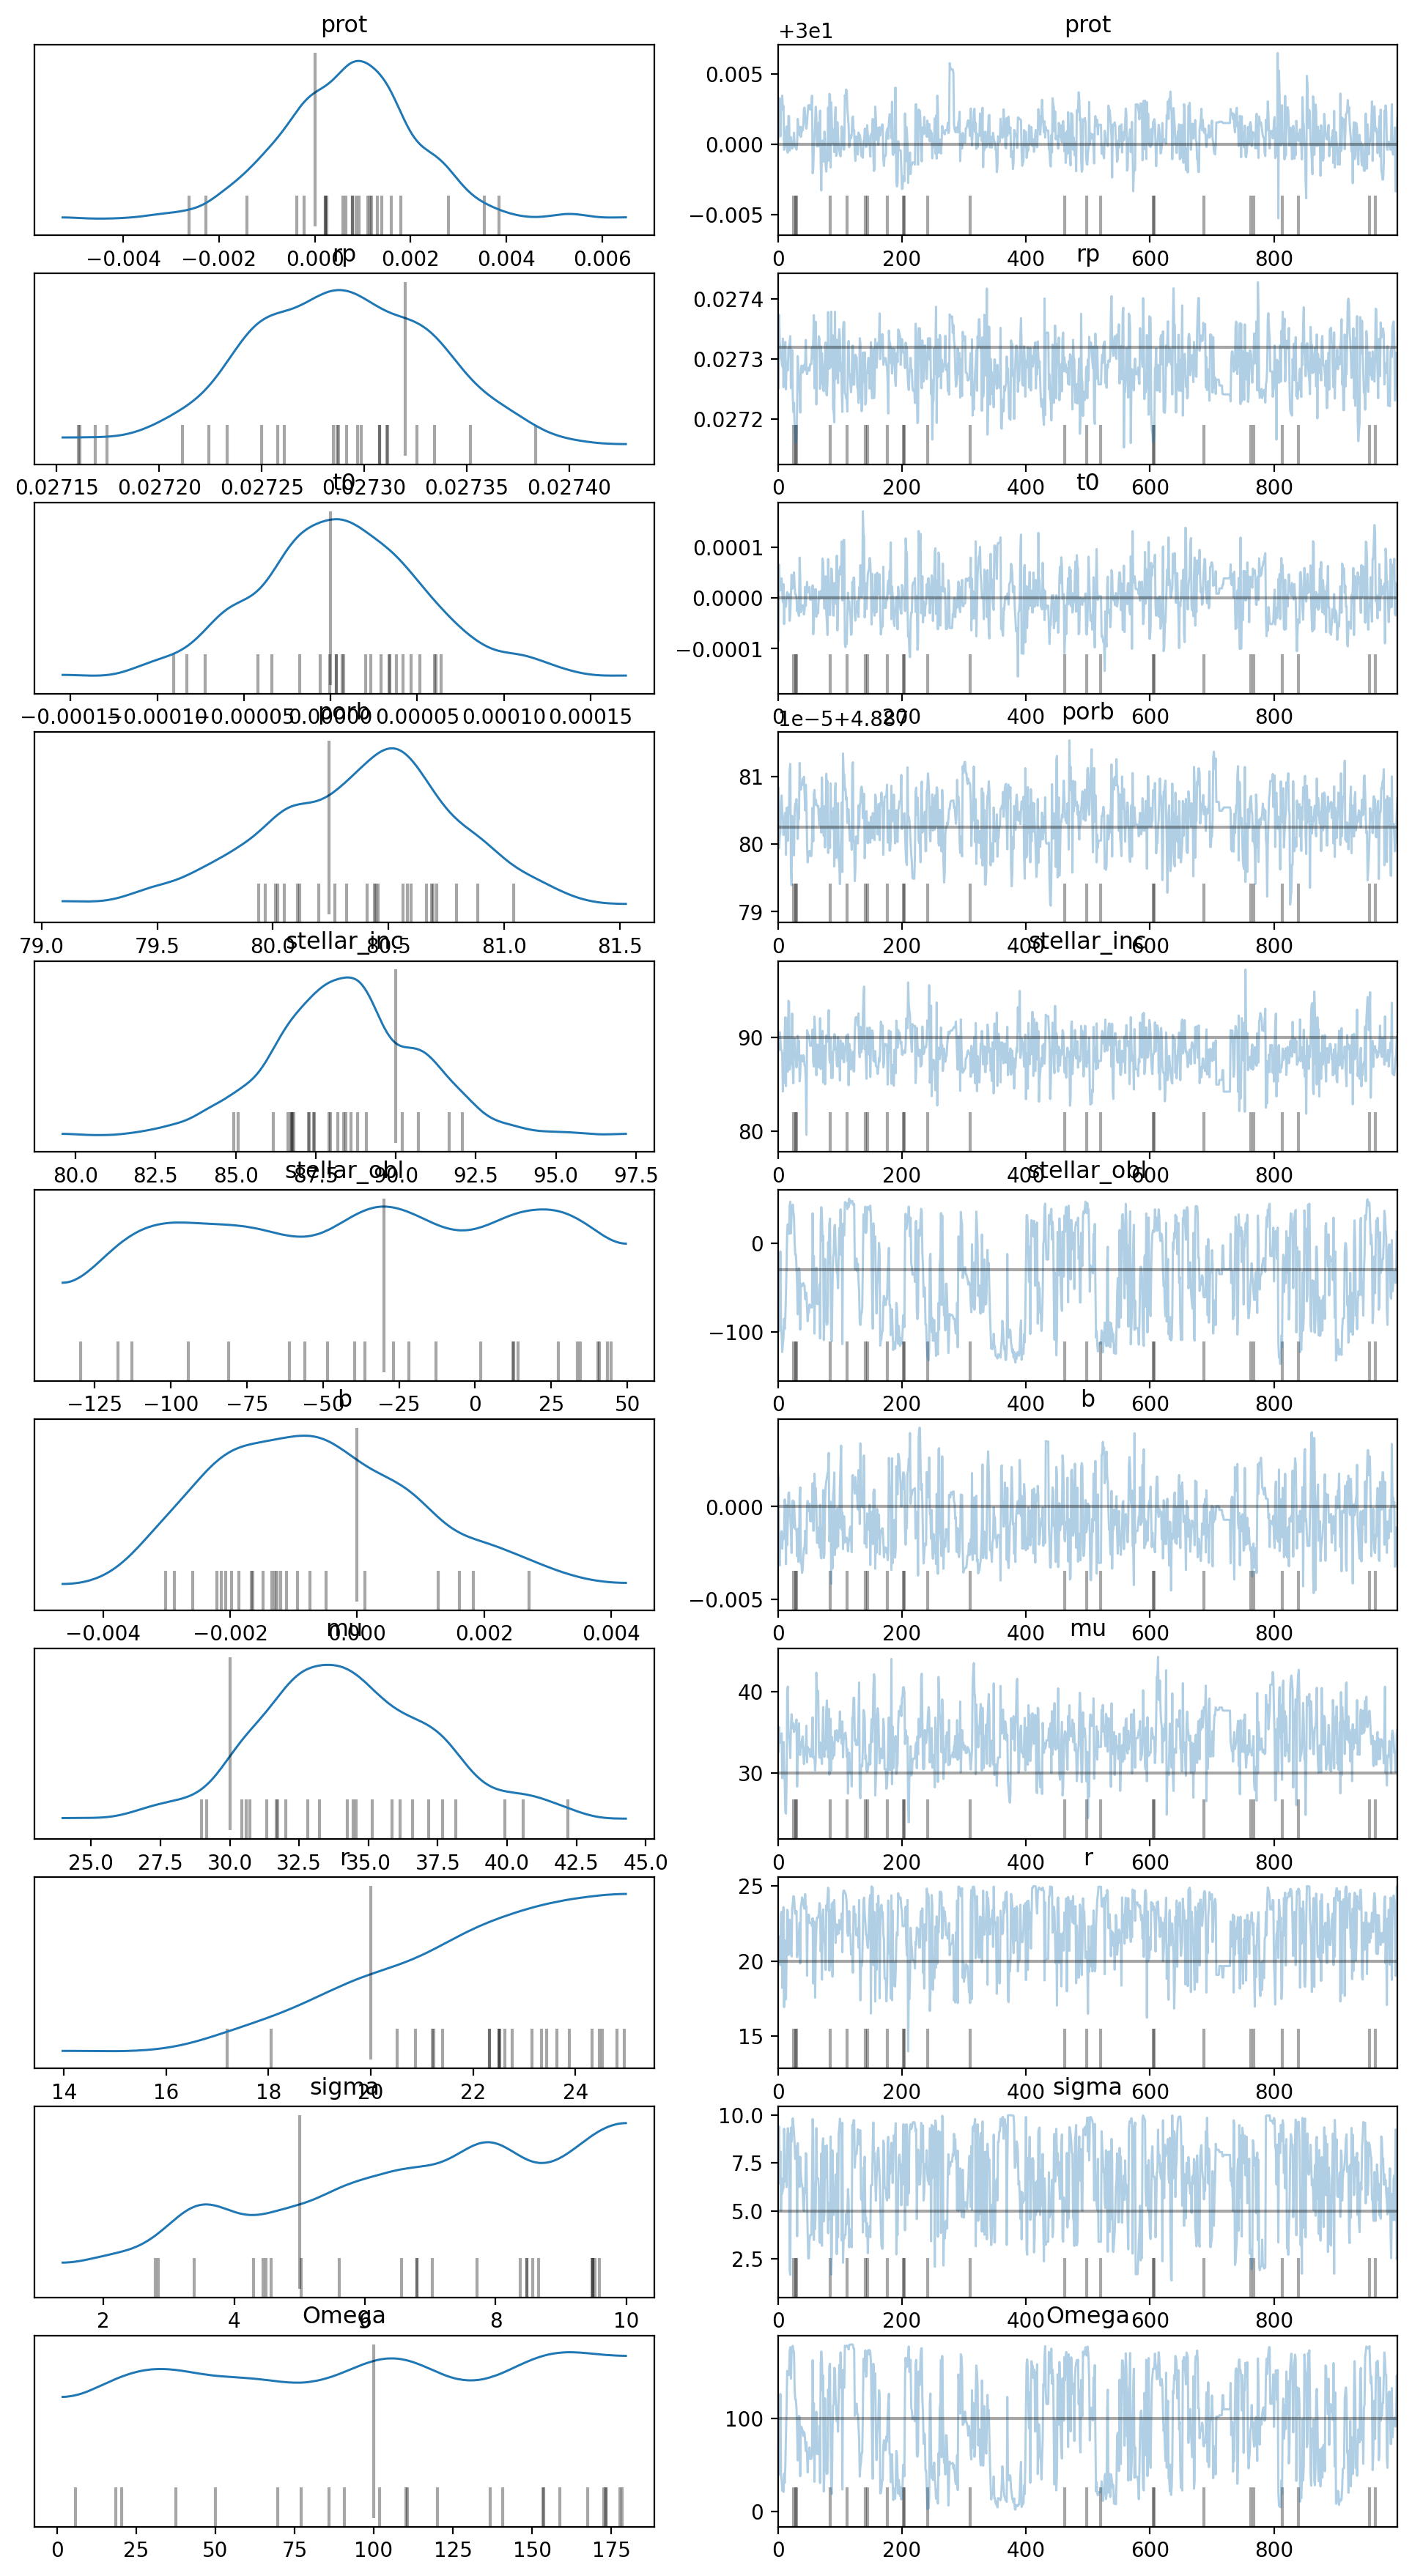

In [30]:
az.plot_trace(trace, var_names=['prot', 'rp', 't0', 'porb', 'stellar_inc', 'stellar_obl', 'b', 'mu', 'r', 'sigma', 'Omega'],
              lines=[('prot', {}, pri.prot.eval()), 
                     ('rp', {}, sec.r.eval()),
                     ('t0', {}, 0),
                     ('porb', {}, sec.porb.eval()),
                     ('stellar_inc', {}, 90.0), # pri.map.inc.eval()),
                     ('stellar_obl', {}, -30),
                     ('b', {}, 0),
                     ('mu', {}, 30),
                     ('r', {}, 20),
                     ('sigma', {}, 5),
                     ('Omega', {}, 100)])

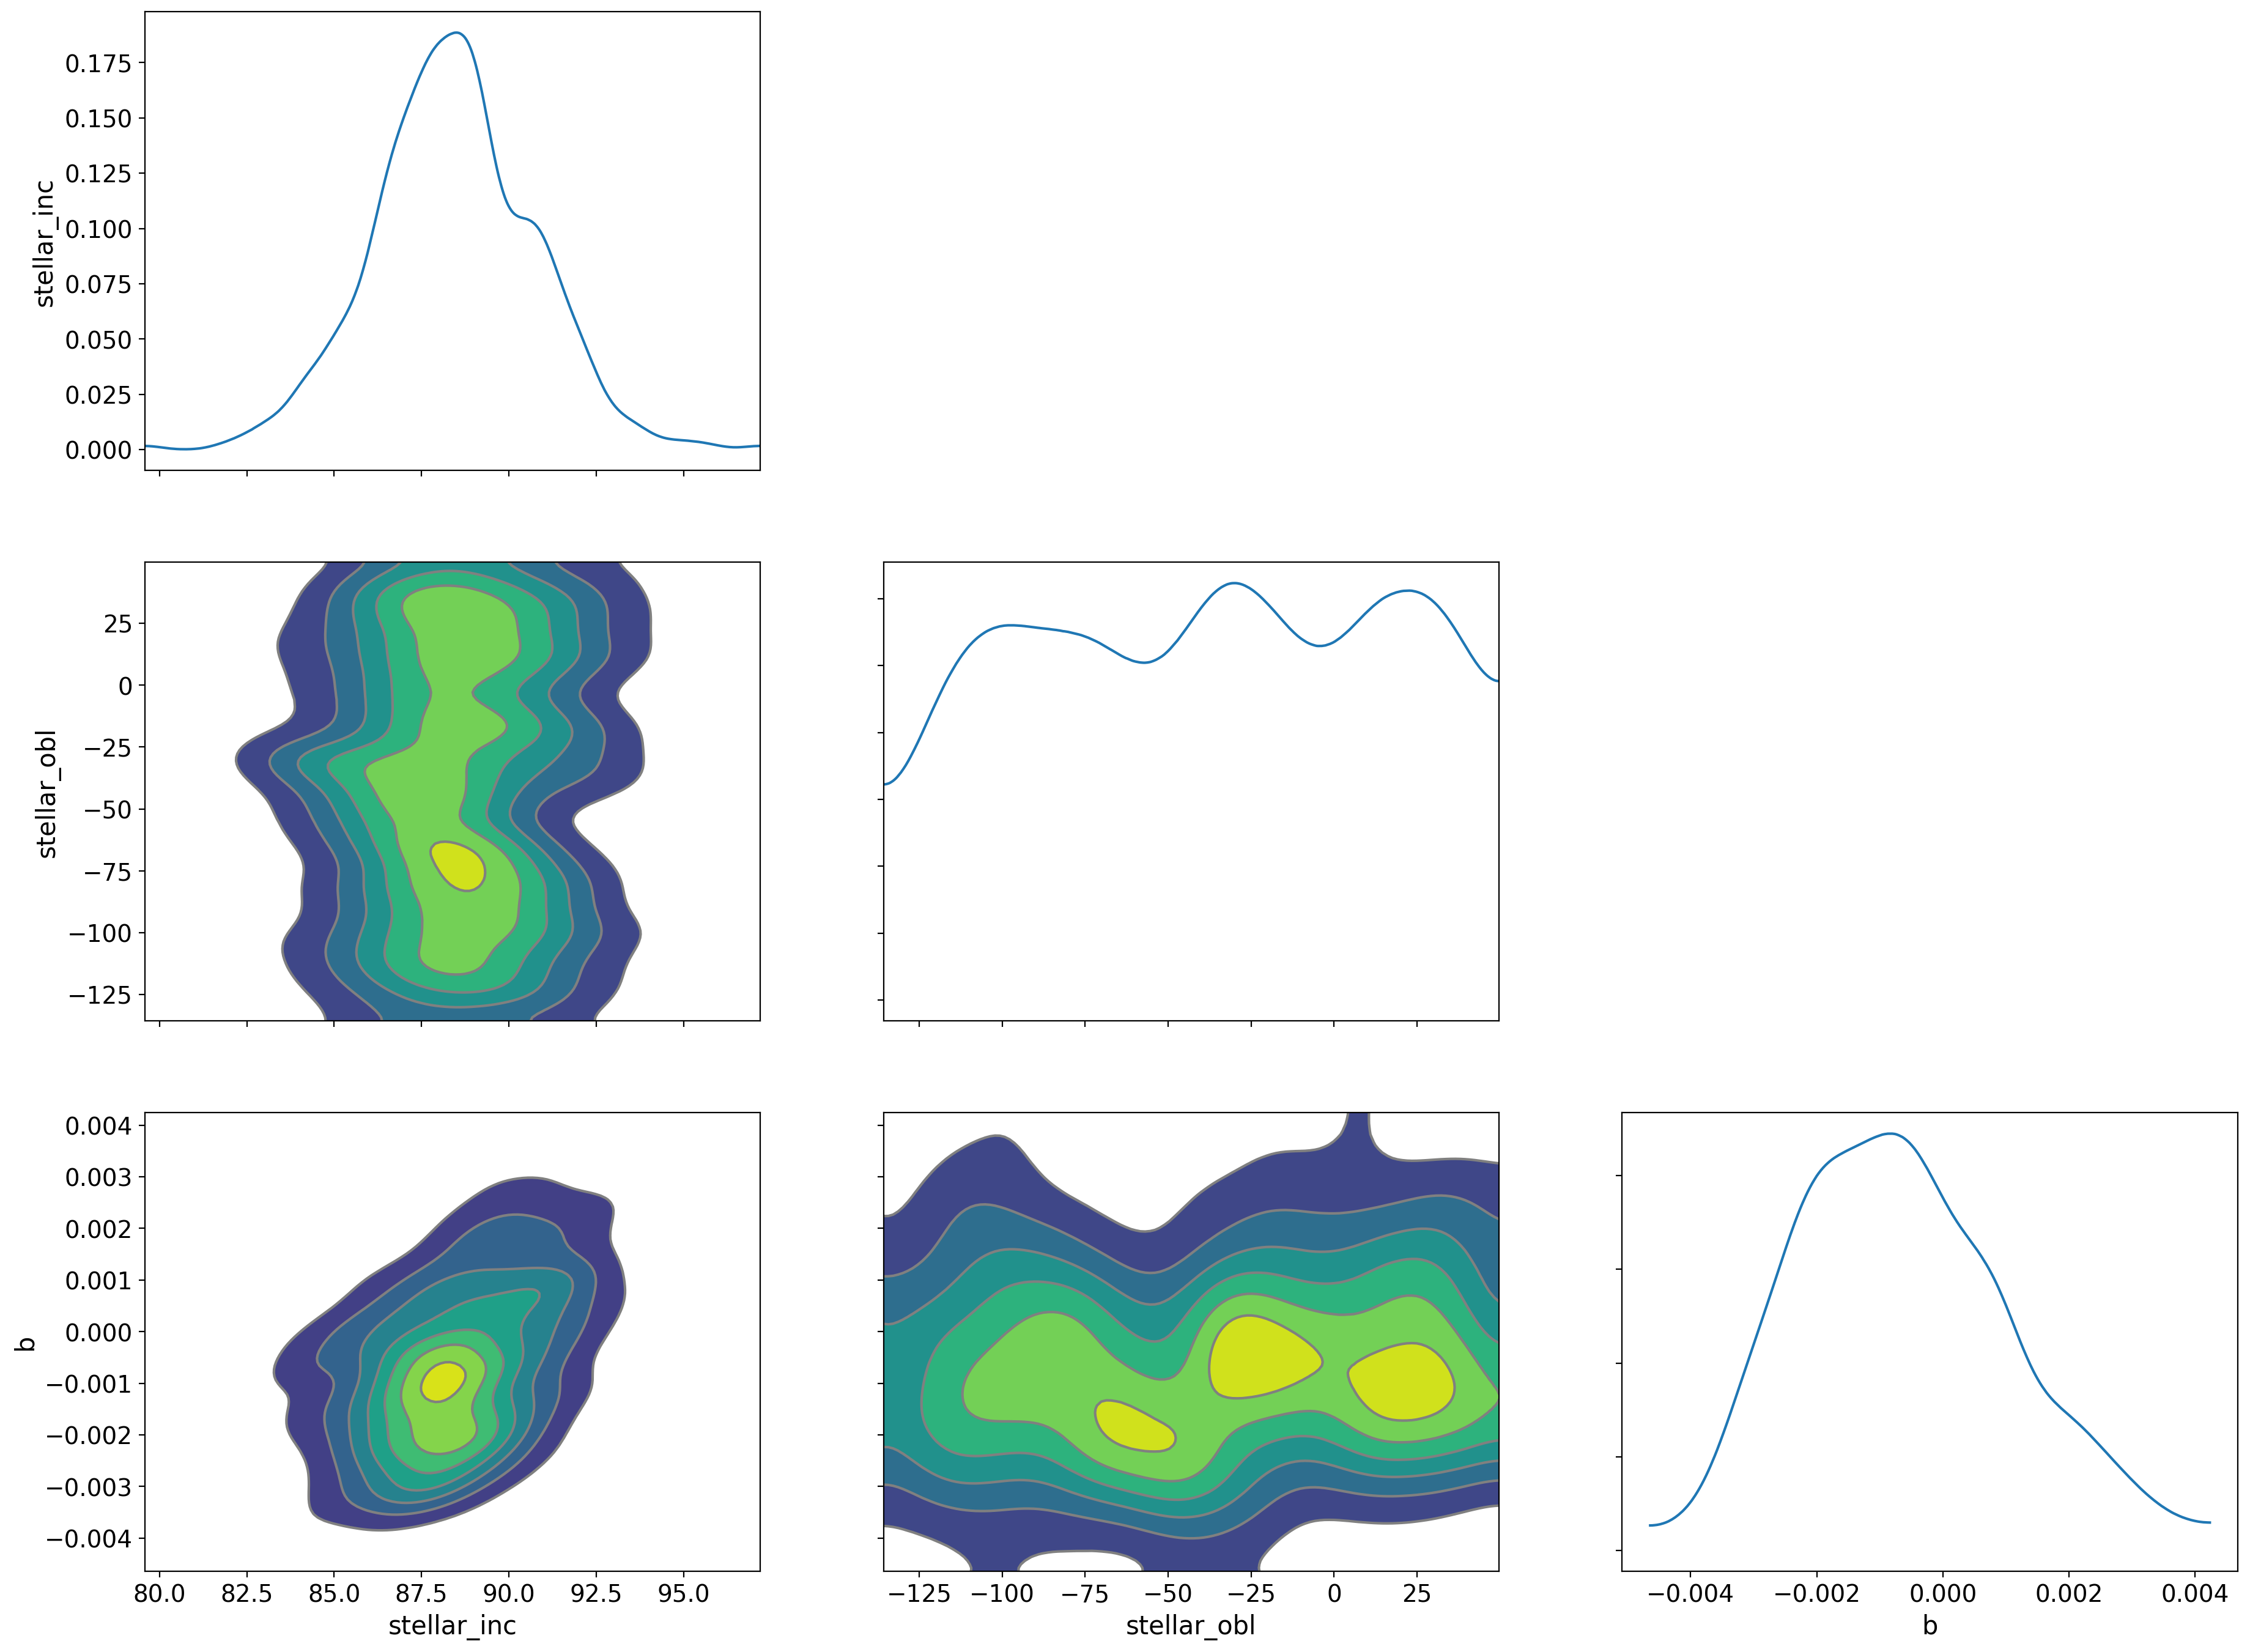

In [31]:
grid = az.plot_pair(trace, var_names=['stellar_inc', 'stellar_obl', 'b'], kind='kde', marginals=True)

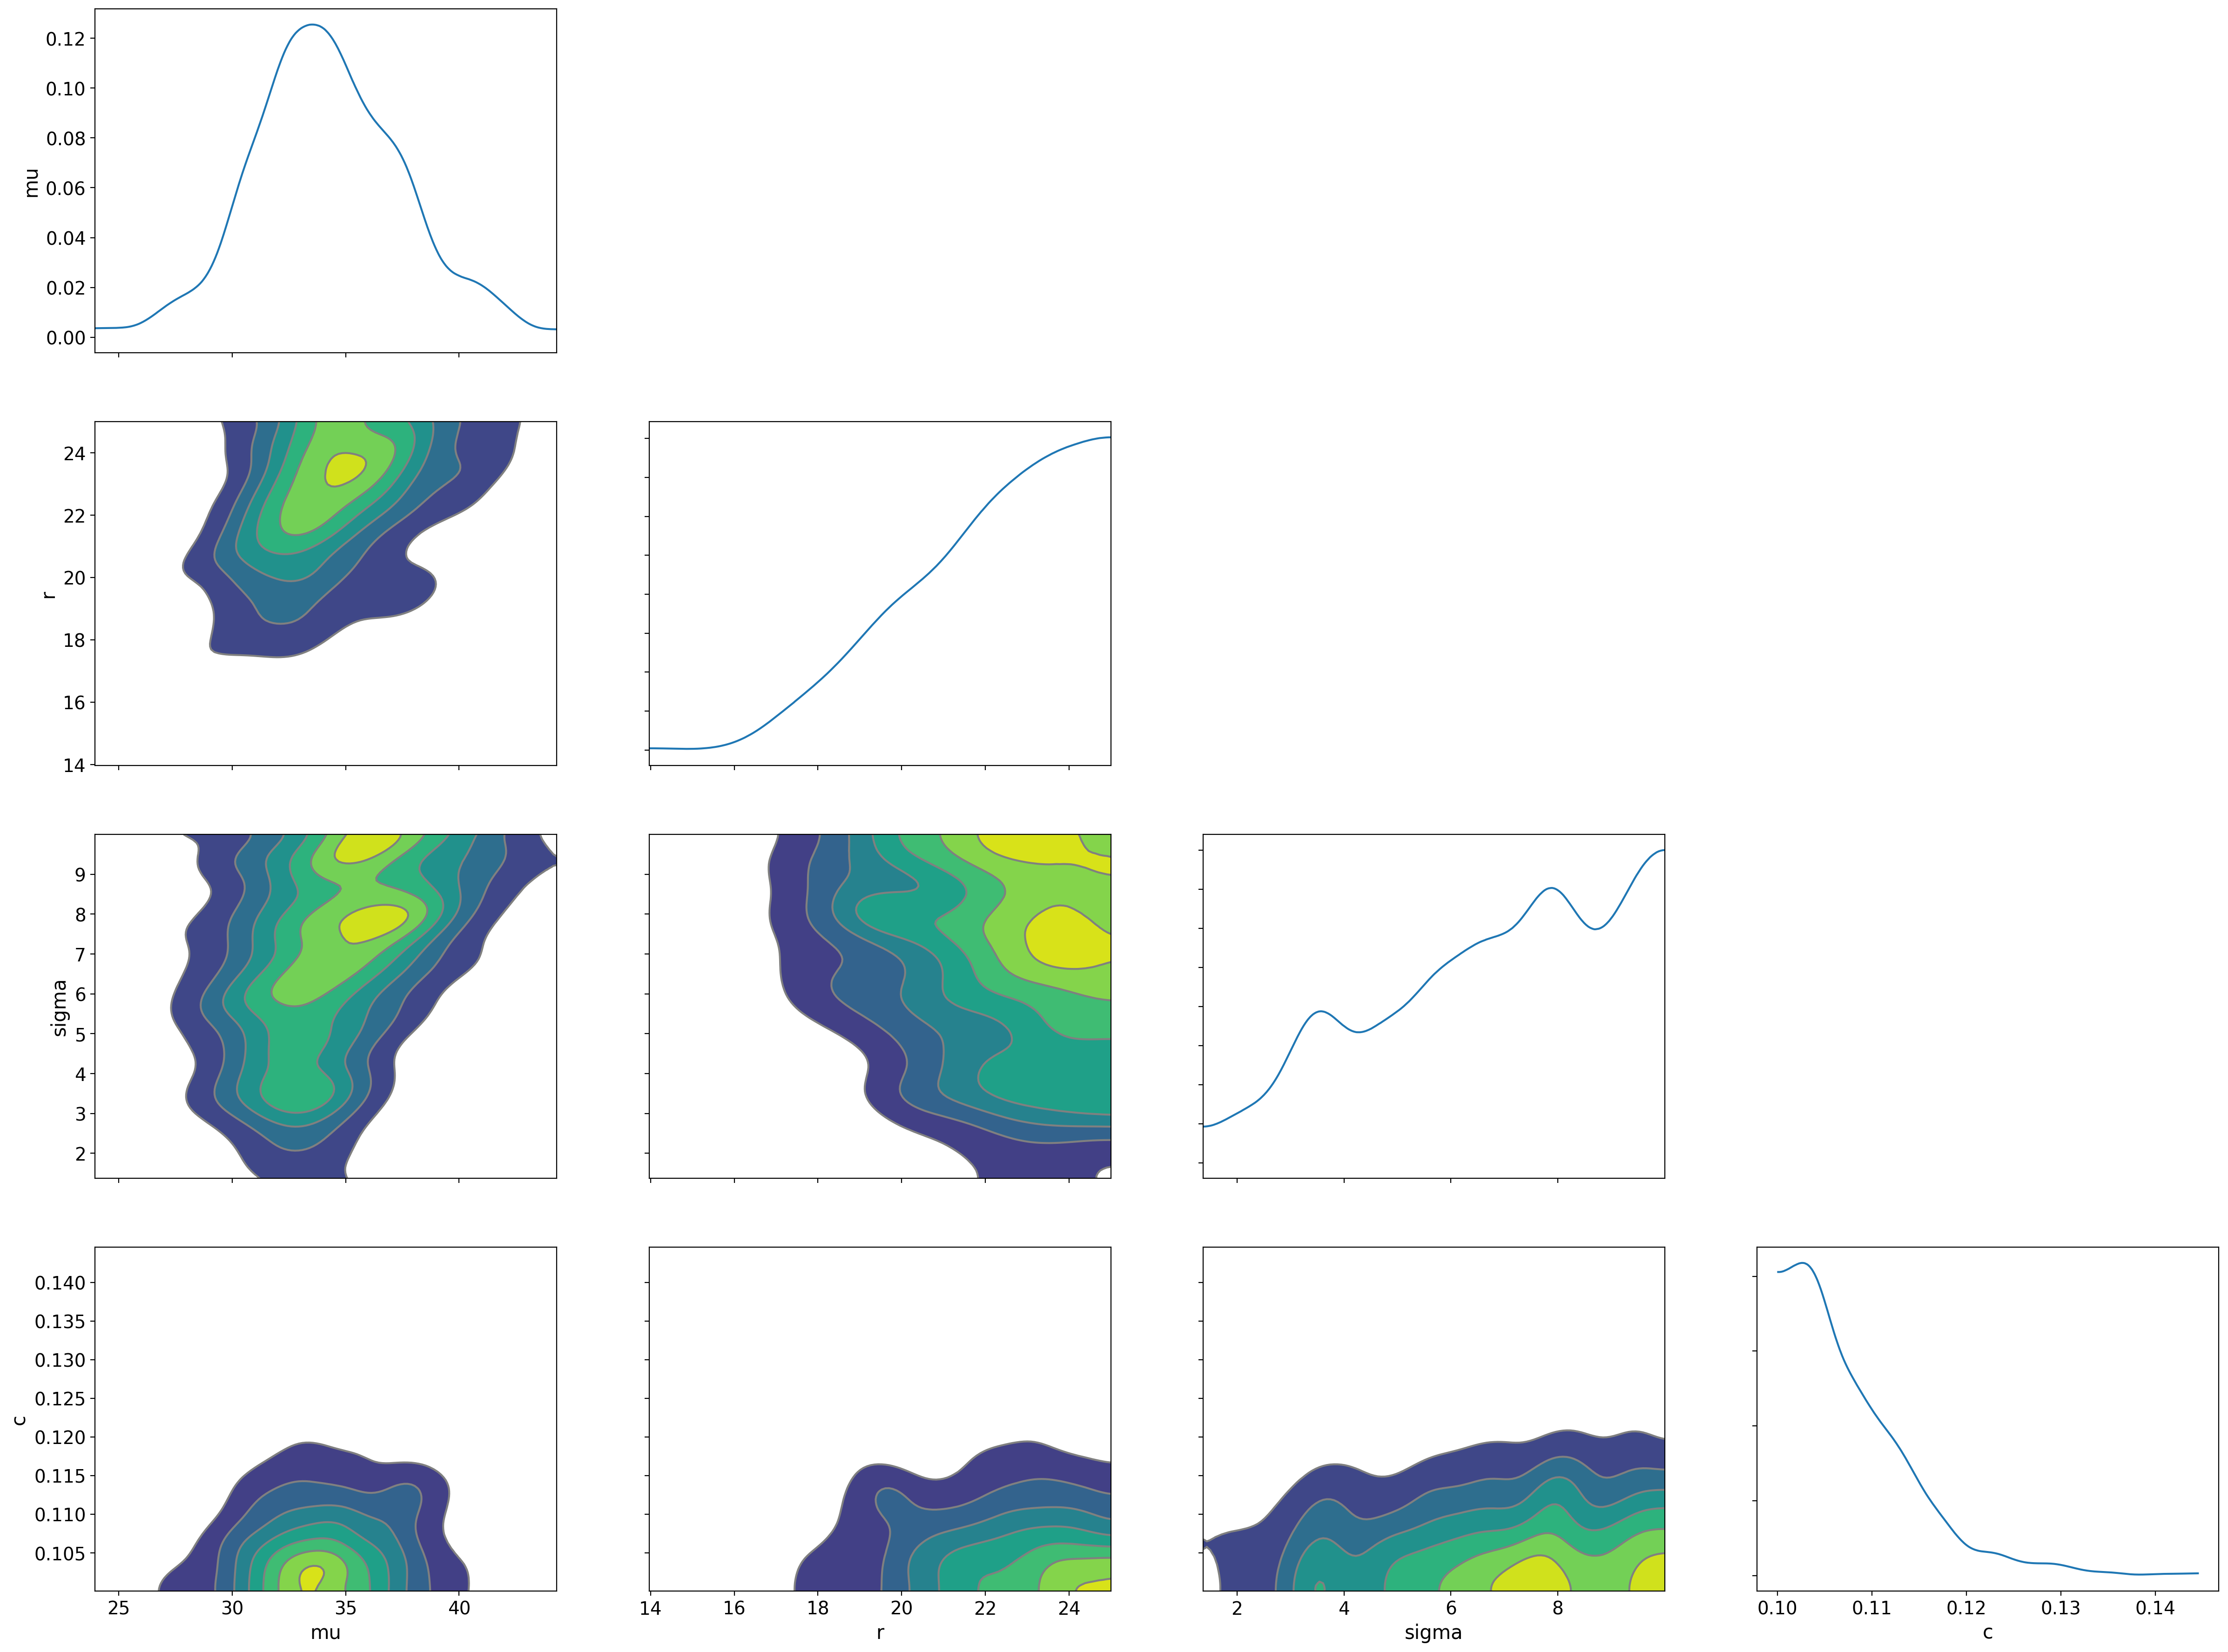

In [38]:
grid = az.plot_pair(trace, var_names=['mu', 'r', 'sigma', 'c'], kind='kde', marginals=True)

array([[<Axes: ylabel='porb'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='t0'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='porb', ylabel='Omega'>, <Axes: xlabel='t0'>,
        <Axes: xlabel='Omega'>]], dtype=object)

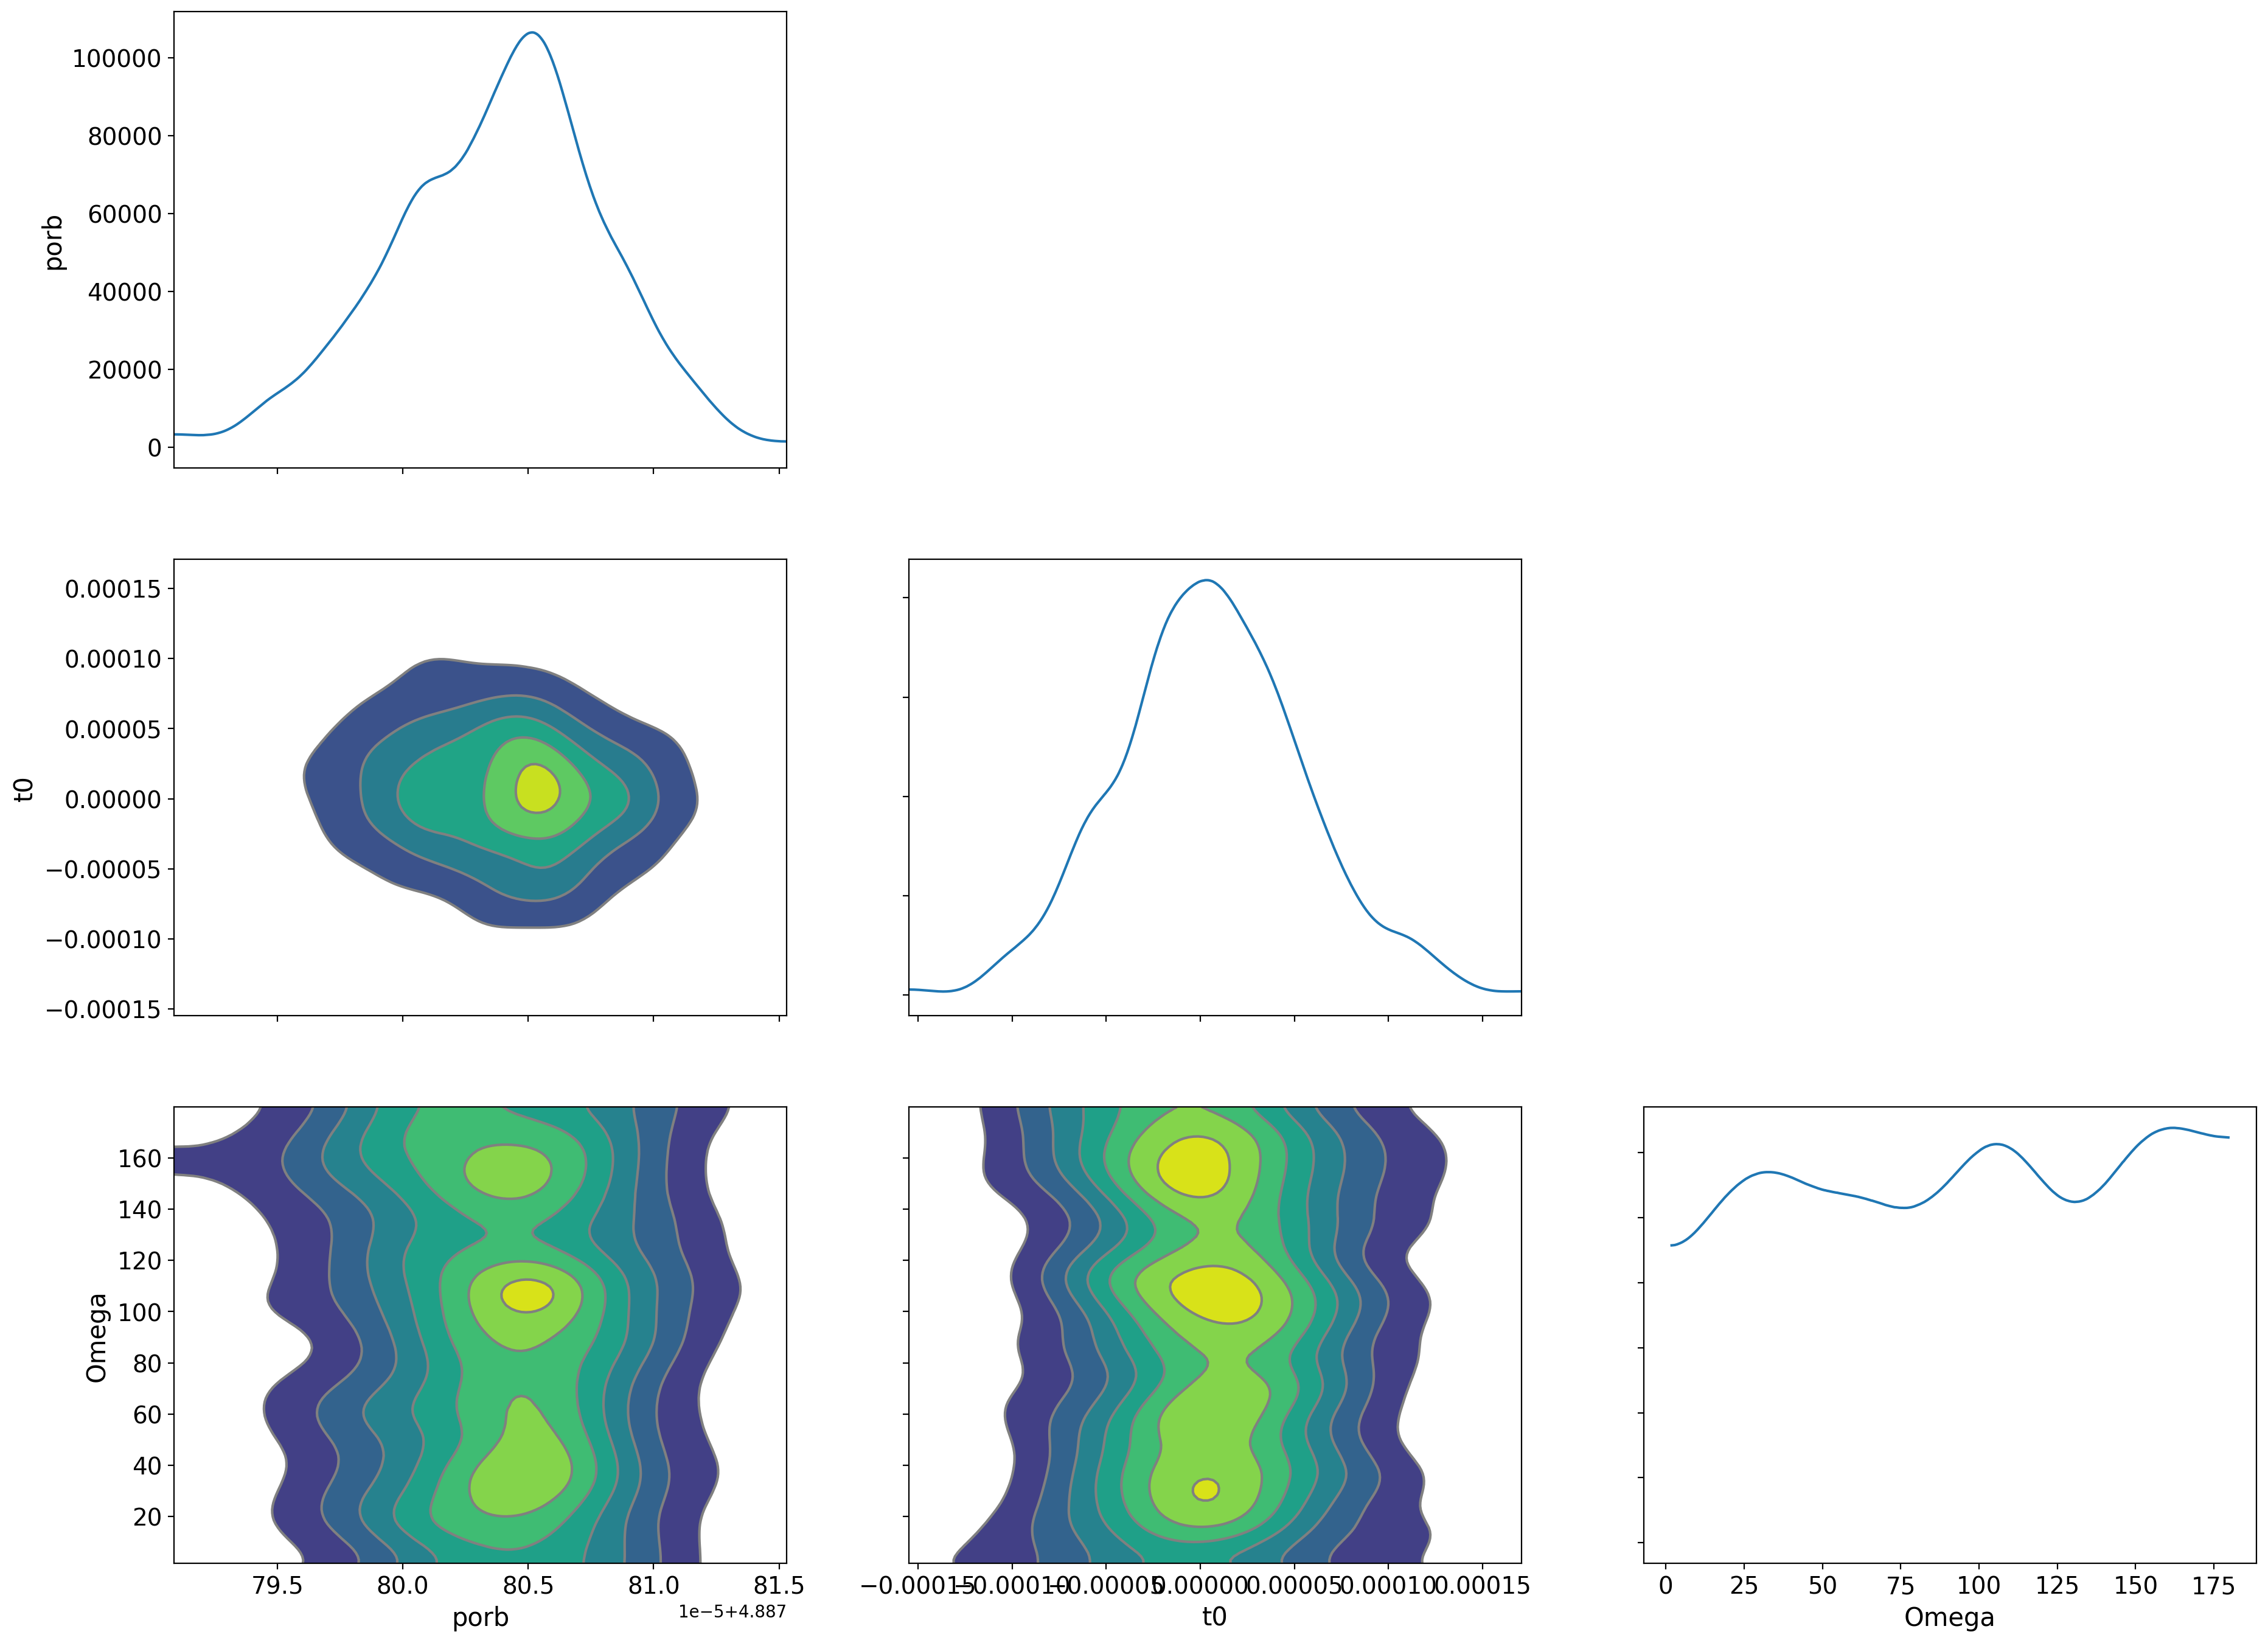

In [33]:
az.plot_pair(trace, var_names=['porb', 't0', 'Omega'], kind='kde', marginals=True)

In [34]:
p = trace.posterior.sel(chain=0, draw=0)

In [35]:
p

<xarray.Dataset>
Dimensions:        ()
Coordinates:
    chain          int64 0
    draw           int64 0
Data variables: (12/19)
    stellar_ori_x  float64 1.943
    stellar_ori_y  float64 -0.5587
    stellar_ori_z  float64 0.0217
    log_prot       float64 3.401
    prot           float64 30.0
    log_porb       float64 1.587
    ...             ...
    planet_inc     float64 89.89
    Omega          float64 115.6
    mu             float64 32.8
    sigma          float64 7.372
    r              float64 21.46
    c              float64 0.1003
Attributes:
    created_at:                 2023-07-17T09:56:49.060942
    arviz_version:              0.12.1
    inference_library:          pymc3
    inference_library_version:  3.11.5
    sampling_time:              28978.226636648178
    tuning_steps:               1000

In [36]:
az.to_netcdf(trace, 'SSP-trace-spparams-Omega.nc')

'SSP-trace-spparams-Omega.nc'

In [46]:
az_trace = az.from_netcdf('SSP-trace-spparams.nc')

In [39]:
map_ylms = []
f = theano.function([model.prot, model.porb, model.stellar_inc, model.stellar_obl, model.b, model.t0, model.rp, model.r, model.mu, model.sigma, model.c, model.Omega], 
                    ssp_model.sample_ylm_conditional(t, flux_obs, sigma_flux))

for c in trace.posterior.coords['chain']:
    for d in trace.posterior.coords['draw']:
        p = trace.posterior.sel(chain=c, draw=d)
        map_ylms.append(f(p.prot, p.porb, p.stellar_inc, p.stellar_obl, p.b, p.t0, p.rp, p.r, p.mu, p.sigma, p.c, p.Omega))

In [40]:
map_ylms = np.array(map_ylms)
map_ylms = np.reshape(map_ylms, (1, -1, ssp.nlm))

/Users/sabina/Desktop/GitHub/starry_process/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


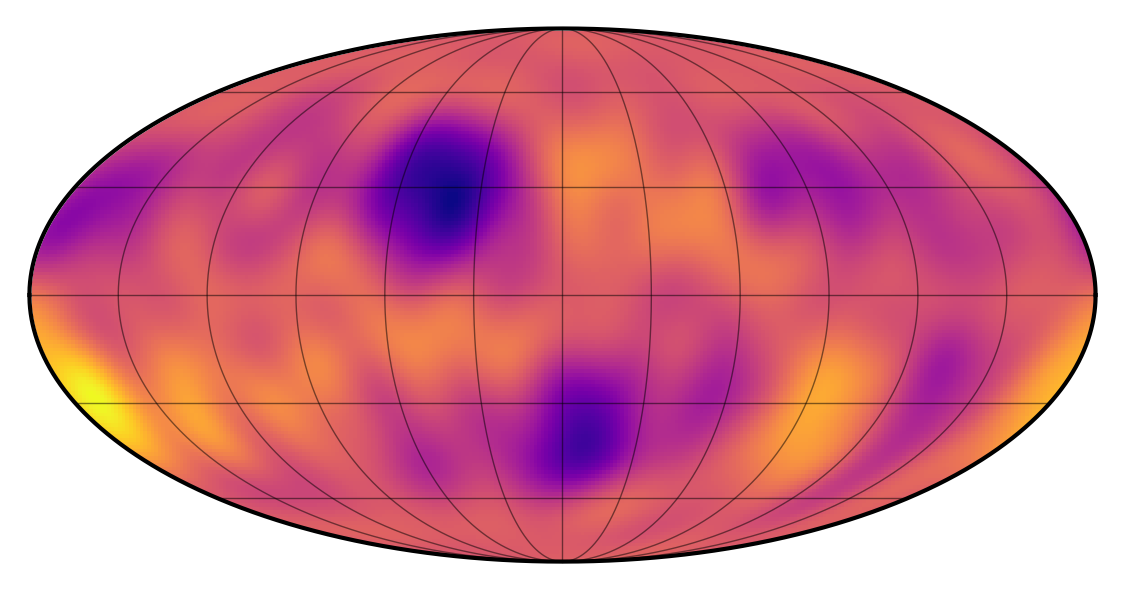

In [41]:
sp_model.visualize(y_true)

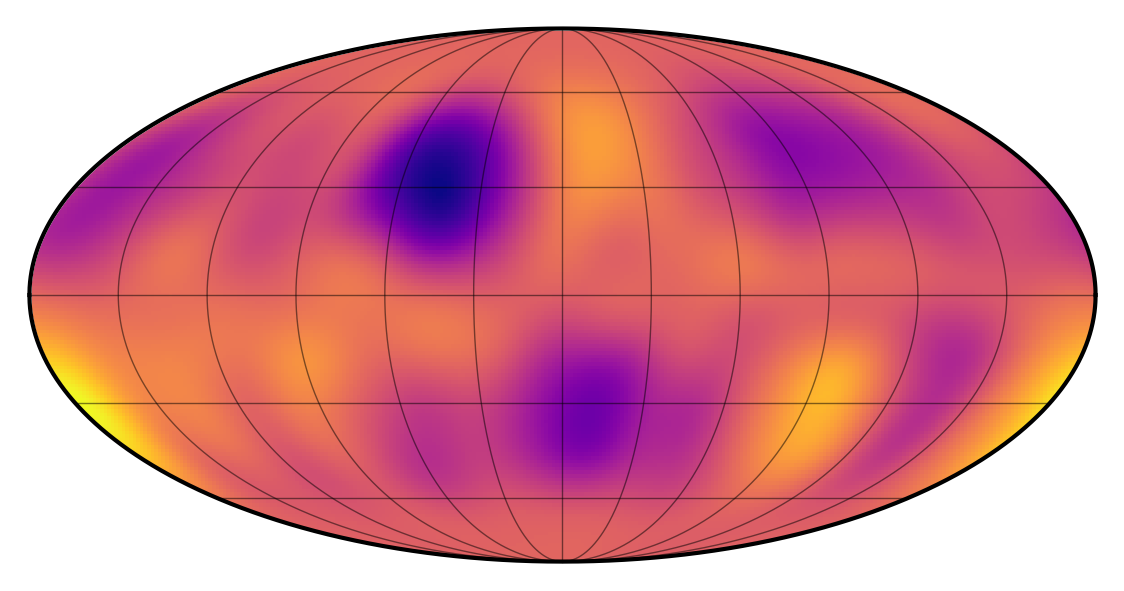

In [42]:
sp_model.visualize(np.mean(map_ylms, axis=(0,1)))

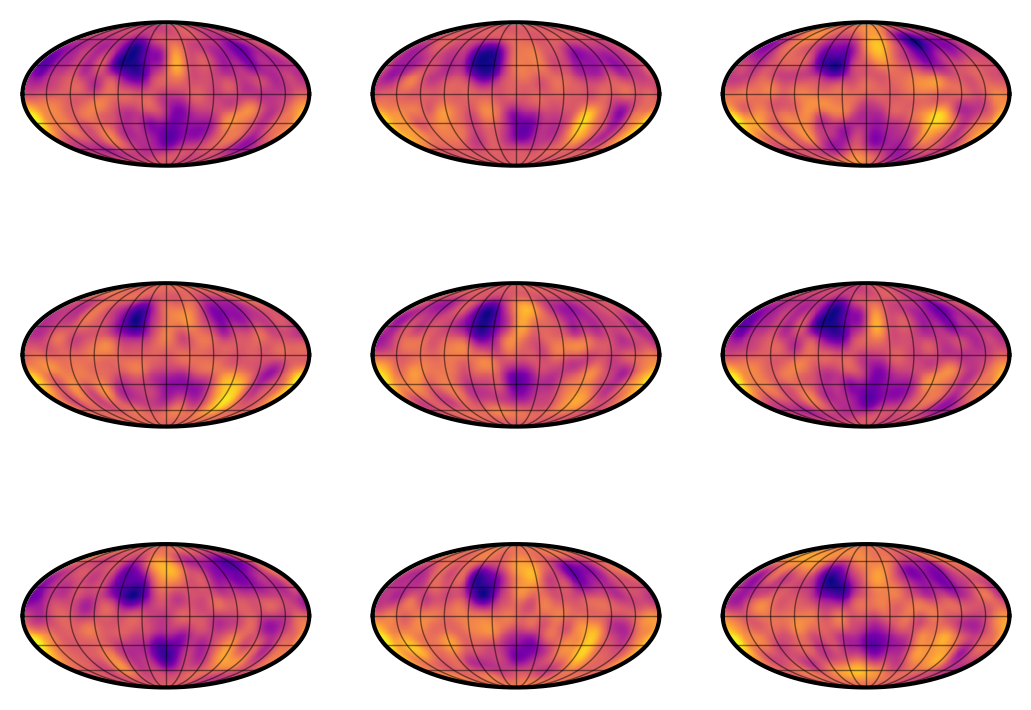

In [43]:
fig, axs = plt.subplots(3, 3)
for ax in axs.flatten():
    i = np.random.randint(map_ylms.shape[0])
    j = np.random.randint(map_ylms.shape[1])

    y = map_ylms[i,j,:]

    sp_model.visualize(y, ax=ax)